## Chapter 16 - Metric-Predicted Variable on One or Two Groups

- [16.1 - Estimating the mean and standard deviation of a normal distribution](#16.1---Estimating-the-mean-and-standard-deviation-of-a-normal-distribution)
- [16.2 - Outliers and robust estimation: the t distribution](#16.2---Outliers-and-robust-estimation:-the-t-distribution)
- [16.3 - Two Groups](#16.2---Two-Groups)


In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm, t
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn,scipy

pandas 0.23.4
numpy 1.15.0
pymc3 3.5
matplotlib 2.2.3
seaborn 0.9.0
scipy 1.1.0


### Data

In [3]:
df = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Score    120 non-null int64
Group    120 non-null category
dtypes: category(1), int64(1)
memory usage: 1.2 KB


In [4]:
df.head()

,Score,Group
0,102,Smart Drug
1,107,Smart Drug
2,92,Smart Drug
3,101,Smart Drug
4,110,Smart Drug


In [5]:
# Mean and standard deviation
df.groupby('Group').agg(['mean', 'std'])

Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

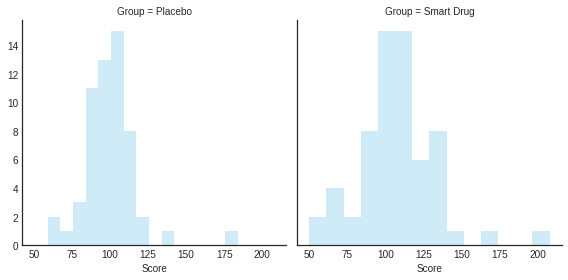

In [6]:
fg = sns.FacetGrid(df, col='Group', height=4)
fg.map(sns.distplot, 'Score', kde=False, color='#87ceeb');

In [7]:
# We are only interested in the scores of group 'Smart Drug'
y = df['Score'][df.Group == 'Smart Drug']

### 16.1 - Estimating the mean and standard deviation of a normal distribution

#### Model (Kruschke, 2015)

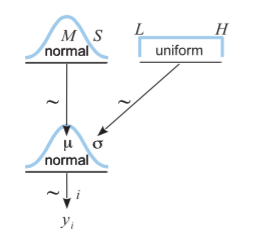

In [8]:
Image('images/fig16_2.png', width=300)

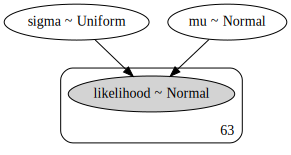

In [9]:
with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pm.Normal('likelihood', mu, sd=sigma, observed=y)

pm.model_to_graphviz(model)

In [10]:
with model:
    trace = pm.sample(2000, cores=4,  nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 3020.62draws/s]


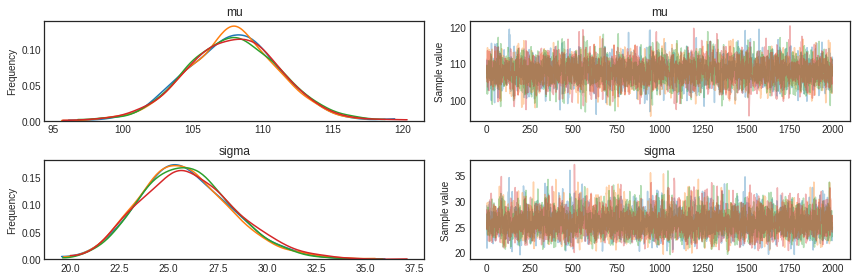

In [11]:
pm.traceplot(trace);

#### Figure 16.3

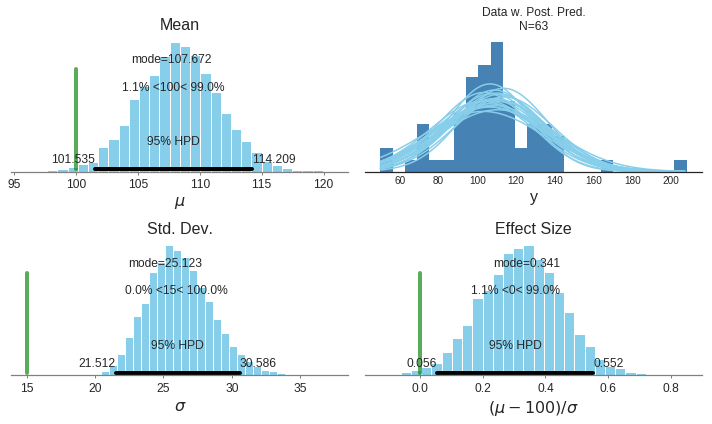

In [12]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

font_d = {'size':16}

# Upper left
pm.plot_posterior(trace['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = len(trace)
# Plot only 20 posterior prediction curves. 
n_curves = 20
# Create an index of length 20 with which we step through the trace.
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace['mu'][stepIdxVec], trace['sigma'][stepIdxVec]), c=color)
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.\nN=63')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
pm.plot_posterior(trace['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Lower right
pm.plot_posterior((trace['mu']-100)/trace['sigma'], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

plt.tight_layout();

### 16.2 - Outliers and robust estimation: the t distribution

#### Model

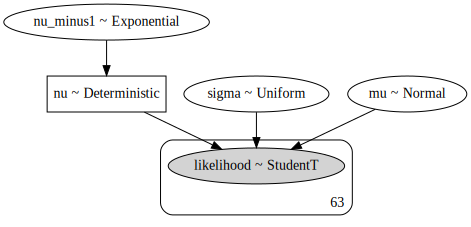

In [13]:
with pm.Model() as model2:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    likelihood = pm.StudentT('likelihood', nu,  mu, sd=sigma, observed=y)

pm.model_to_graphviz(model2)

In [14]:
with model2:
    trace2 = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, mu]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:09<00:00, 2218.69draws/s]


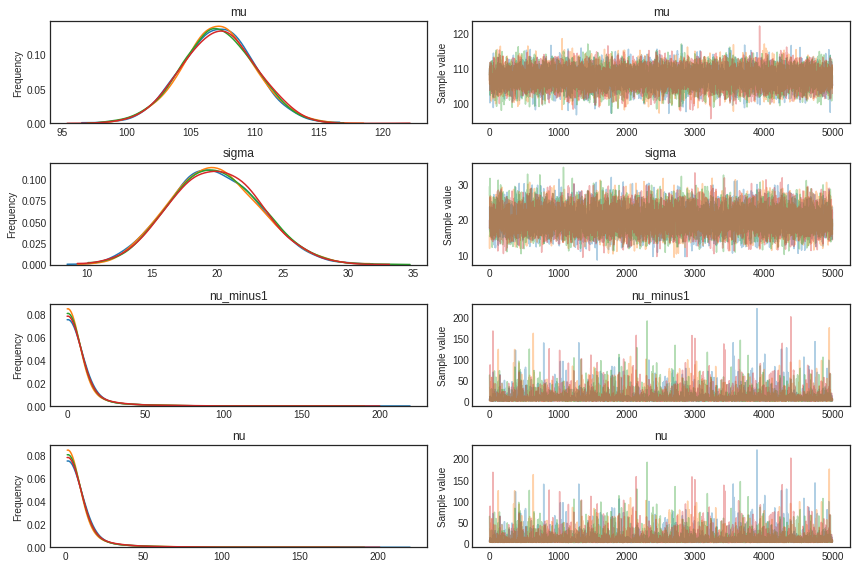

In [15]:
pm.traceplot(trace2);

#### Figure 16.9

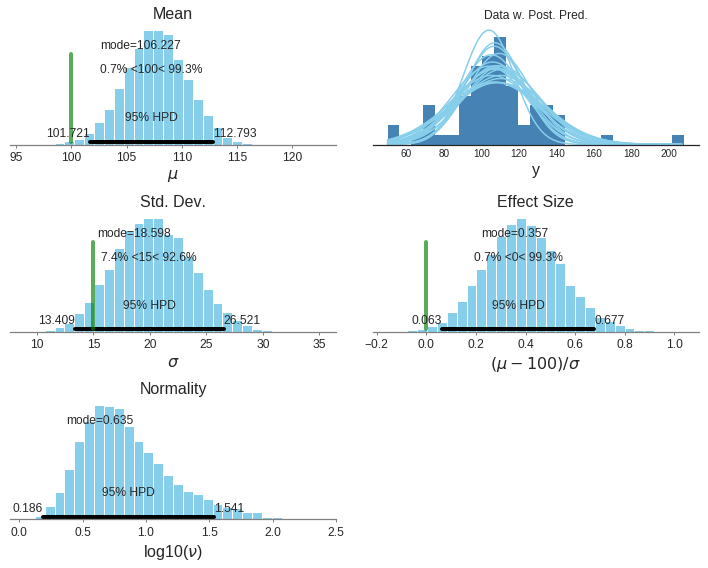

In [16]:
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3,2, figsize=(10,8))

# Upper left
pm.plot_posterior(trace2['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = len(trace)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace2['mu'][stepIdxVec], trace2['sigma'][stepIdxVec]), c='#87ceeb')
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Middle left
pm.plot_posterior(trace2['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Middle right
pm.plot_posterior((trace2['mu']-100)/trace2['sigma'], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

# Lower left
pm.plot_posterior(np.log10(trace2['nu']), point_estimate='mode', ax=ax5, color=color)
ax5.set_title('Normality', fontdict=font_d)
ax5.set_xlabel(r'log10($\nu$)', fontdict=font_d)

plt.tight_layout();
ax6.set_visible(False)

### 16.2 - Two Groups

#### Model (Kruschke, 2015)

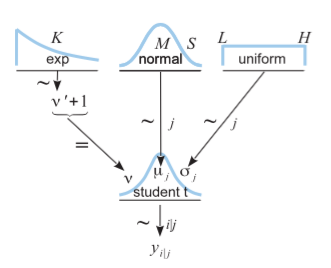

In [17]:
Image('images/fig16_11.png', width=400)

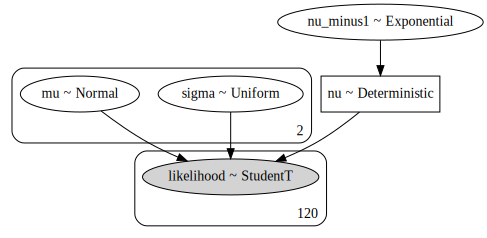

In [18]:
grp_idx = df.Group.cat.codes.values
grp_codes = df.Group.cat.categories
n_grps = grp_codes.size

with pm.Model() as model3:
    mu = pm.Normal('mu', df.Score.mean(), sd=df.Score.std(), shape=n_grps)
    sigma = pm.Uniform('sigma', df.Score.std()/1000, df.Score.std()*1000, shape=n_grps)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
        
    likelihood = pm.StudentT('likelihood', nu,  mu[grp_idx], sd=sigma[grp_idx], observed=df.Score)

pm.model_to_graphviz(model3)

In [19]:
with model3:
    trace3 = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, mu]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:10<00:00, 2030.42draws/s]


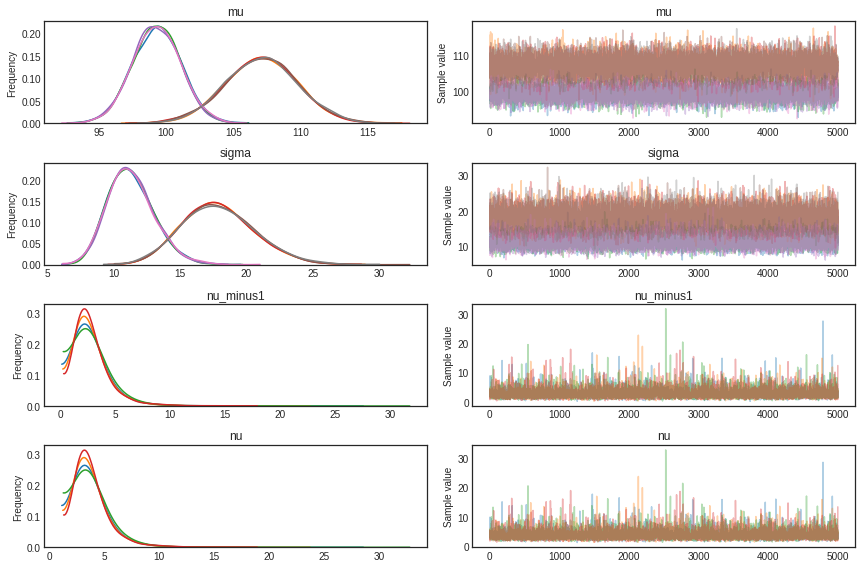

In [20]:
pm.traceplot(trace3);

#### Figure 16.12

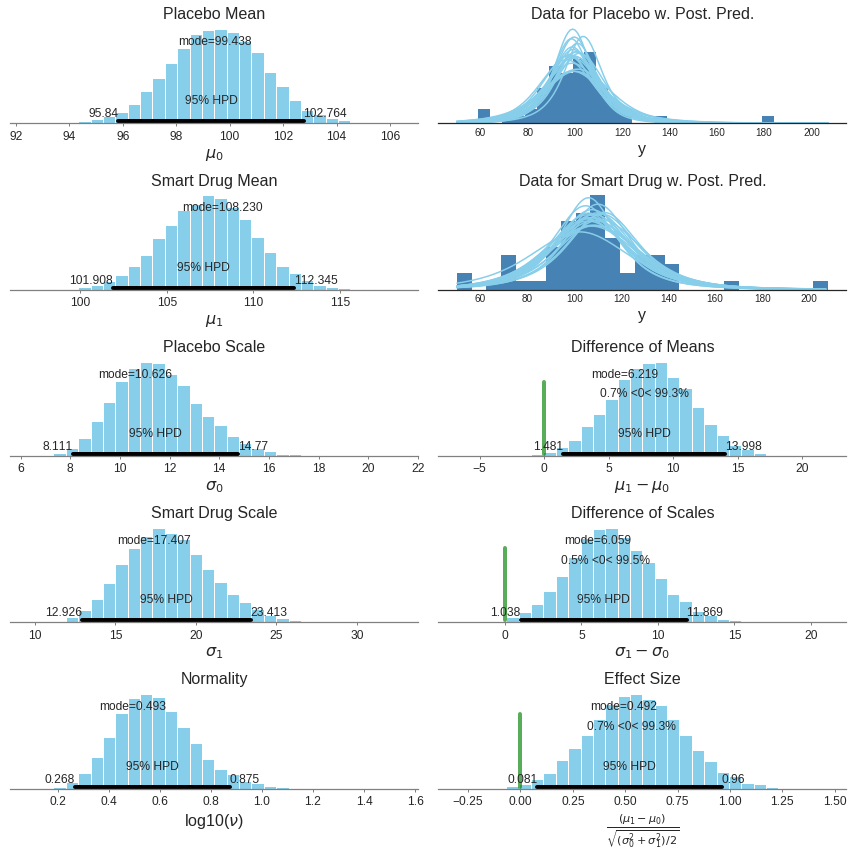

In [21]:
tr3_mu0 = trace3['mu'][:,0]
tr3_mu1 = trace3['mu'][:,1]
tr3_sigma0 = trace3['sigma'][:,0]
tr3_sigma1 = trace3['sigma'][:,1]
tr3_nu = np.log10(trace3['nu'])

fig, axes = plt.subplots(5,2, figsize=(12, 12))

# Left column figs
l_trace_vars = (tr3_mu0, tr3_mu1, tr3_sigma0, tr3_sigma1, tr3_nu)
l_axes_idx = np.arange(5)
l_xlabels = ('$\mu_0$', '$\mu_1$', '$\sigma_0$', '$\sigma_1$', r'log10($\nu$)')
l_titles = ('Placebo Mean', 'Smart Drug Mean', 'Placebo Scale', 'Smart Drug Scale', 'Normality')

for var, ax_i, xlabel, title in zip(l_trace_vars, l_axes_idx, l_xlabels, l_titles): 
    pm.plot_posterior(var, point_estimate='mode', ax=axes[ax_i,0], color=color)
    axes[ax_i,0].set_xlabel(xlabel, font_d)
    axes[ax_i,0].set_title(title, font_d)

# Right column figs
tr_len = len(trace3)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(df.Score.min(), df.Score.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

# 1
axes[0,1].hist(df.Score[df.Group == 'Placebo'], bins=25, density=True, color='steelblue')
axes[0,1].plot(x, t.pdf(x, loc=tr3_mu0[stepIdxVec], scale=tr3_sigma0[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), c='#87ceeb')
axes[0,1].set_xlabel('y', font_d)
[axes[0,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[0,1].yaxis.set_visible(False)
axes[0,1].set_title('Data for Placebo w. Post. Pred.', font_d)

# 2
axes[1,1].hist(df.Score[df.Group == 'Smart Drug'], bins=25, density=True, color='steelblue')
axes[1,1].plot(x, t.pdf(x, loc=tr3_mu1[stepIdxVec], scale=tr3_sigma1[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), c='#87ceeb')
axes[1,1].set_xlabel('y', font_d)
[axes[1,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_title('Data for Smart Drug w. Post. Pred.', font_d)

# 3-5
r_vars = (tr3_mu1-tr3_mu0,
          tr3_sigma1-tr3_sigma0,
          (tr3_mu1-tr3_mu0)/np.sqrt((tr3_sigma0**2+tr3_sigma1**2)/2))
r_axes_idx = np.arange(start=2, stop=5)
r_xlabels = ('$\mu_1 - \mu_0$',
             '$\sigma_1 - \sigma_0$',
             r'$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$')
r_titles = ('Difference of Means',
            'Difference of Scales',
            'Effect Size')

for var, ax_i, xlabel, title in zip(r_vars, r_axes_idx, r_xlabels, r_titles):
    pm.plot_posterior(var, point_estimate='mode', ref_val=0, ax=axes[ax_i,1], color=color)
    axes[ax_i,1].set_xlabel(xlabel, font_d)
    axes[ax_i,1].set_title(title, font_d)

plt.tight_layout();